In [2]:
import os, glob, pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
from PIL import Image

## Feature extraction
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.layers import Dense, Flatten, Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import mixed_precision
import IPython

c:\Users\fcoel\miniconda3\envs\apc-project\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Notebook description

## Goal

In our proposal, we seek to use a CNN as a feature extractor before using classic Machine Learning algorithms to tackle the classificaiton problem.
The first step is to validate our claim that the features help improve their performance.

## Methods

For that, we pick one model and train it with raw data/CNN features, comparing both results.
We will stick with AdaBoost, and use a pre-trained ResNET50 as our feature extractors. 



### Load data and setup pre-trained ResNET50

In [30]:
# Building Training and Validation Dataframes
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def dataframer(base_dir):
    path = []
    label = []
    for img_class in os.listdir(base_dir):
        label_path = os.path.join(base_dir, img_class)
        if img_class in labels:
            for img in os.listdir(label_path):
                path.append(os.path.join(label_path, img))
                label.append(img_class)
    img_data = pd.DataFrame({'Path': path, 'Label': label})
    return img_data

train_base_dir = "../data/seg_train"
validation_base_dir = "../data/seg_test"

train_img_data = dataframer(train_base_dir)
validation_img_data = dataframer(validation_base_dir)

target_size = (75, 75)


def preprocessing(arr):
    arr = tf.image.rgb_to_grayscale(arr)
    arr = tf.image.resize(arr, target_size)
    return arr

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    preprocessing_function=preprocessing
)

validation_datagen = ImageDataGenerator(
    rescale = 1/255
)

# Generating Batches of the Augmented Data:
batch_size = 360

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_img_data,
    x_col="Path",
    y_col="Label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=False,
    seed=10)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_img_data,
    x_col="Path",
    y_col="Label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

# Build Model
resnet = ResNet50V2(include_top=False, pooling='avg')
resnet.trainable = False # Let's start with frozen resnet weights and train just the dense

# Compile the model
resnet.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

Found 14034 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


../data/seg_train\buildings\1012.jpg


(150, 150, 3)

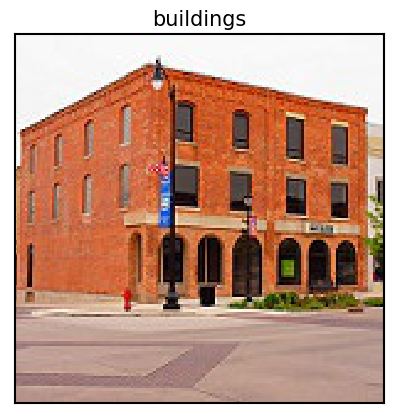

In [17]:
# Visualize the data
sample = train_img_data.iloc[10]
print(sample["Path"])
sample_img = Image.open(sample["Path"])
sample_arr = np.array(sample_img)
ax = isns.imgplot(sample_arr, map_func=np.flip, axis=0)
ax.set_title(sample["Label"])
sample_arr.shape

### Prepare features

In [31]:
def extract_features(model, data_gen):

    features = model.predict(data_gen)

    return features


train_feats = extract_features(resnet, train_generator)
validation_feats = extract_features(resnet, validation_generator)

9/9 [==============================] - 13s 1s/step


In [86]:
with open('../models/embedding_train.pickle', 'wb') as handle:
    pickle.dump(train_feats, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/embedding_validation.pickle', 'wb') as handle:
    pickle.dump(validation_feats, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [5]:
with open('../models/embedding_train.pickle', 'rb') as handle:
    train_feats = pickle.load(handle)

with open('../models/embedding_validation.pickle', 'rb') as handle:
    validation_feats = pickle.load(handle)

In [6]:
print(f"Train features: {train_feats.shape}\nValidation features: {validation_feats.shape}")
print(f"Total features per image: {train_feats[0].size}")
print(f"Number of pixels features per image: {150*150*3}")

Train features: (14034, 2048)
Validation features: (3000, 2048)
Total features per image: 2048
Number of pixels features per image: 67500


### Train XGBoost using raw images

In [7]:
from sklearn import preprocessing

def load_image_data(img_dataframe):
    """ 
    input
    img_dataframe: Dataframe containing two collumns
        - Path: path for images
        - Label: categorical labels
    """

    data = []
    for path in img_dataframe["Path"]:
        img = Image.open(path).resize((75, 75)).convert("L" )
        img_arr = (np.array(img) / 255).astype(np.float16)
        data.append(img_arr.flatten())
    data = np.stack(data)

    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(img_dataframe["Label"])
    
    return data, labels


In [8]:
# Prepare data for training directly on images
train_data, train_labels = load_image_data(train_img_data)
validation_data, validation_labels = load_image_data(validation_img_data)

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score


xgboost = XGBClassifier(objective="multi:softmax", num_class=6, num_estimators=100, max_depth=2, use_label_encoder=False)

scores = cross_val_score(xgboost, train_data, train_labels, scoring="balanced_accuracy")


[13:37:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:37:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_estimators" } might not be used.

  This could be a false alarm, with some parameters getting 

In [20]:
print(f"Mean score: {scores.mean()}")

Mean score: 0.5113529075509542


In [22]:
xgboost.fit(train_data, train_labels)

[14:50:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:50:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_class=6, num_estimators=100, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False, ...)

In [23]:
validation_pred = xgboost.predict(validation_data)

In [25]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(validation_labels, validation_pred)

# We will store the results in a dictionary for easy access later
per_class_accuracies = {}

# Calculate the accuracy for each one of our classes
for idx, cls in enumerate(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']):
    # True negatives are all the samples that are not our current GT class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = cm[idx, idx]
    
    # The accuracy for the current class is ratio between correct predictions to all predictions
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)


In [26]:
per_class_accuracies

{'buildings': 0.8526666666666667,
 'forest': 0.863,
 'glacier': 0.805,
 'mountain': 0.8293333333333334,
 'sea': 0.8143333333333334,
 'street': 0.8603333333333333}

### Train XGBoost on features

In [49]:
from sklearn import preprocessing


le = preprocessing.LabelEncoder()
train_labels = le.fit_transform(train_img_data["Label"])

le = preprocessing.LabelEncoder()
validation_labels = le.fit_transform(validation_img_data["Label"])

In [50]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score


xgboost2 = XGBClassifier(objective="multi:softmax", num_class=6, num_estimators=100, max_depth=2, use_label_encoder=False)

scores2 = cross_val_score(xgboost2, train_feats, train_labels, scoring="balanced_accuracy")


[15:50:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:50:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_estimators" } might not be used.

  This could be a false alarm, with some parameters getting 

In [51]:
print(f"Mean score: {scores2.mean()}")

Mean score: 0.7866348547148894


In [52]:
xgboost2.fit(train_feats, train_labels)

[15:54:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:54:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_class=6, num_estimators=100, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False, ...)

In [54]:
validation_pred2 = xgboost2.predict(validation_feats)

In [55]:
# Get the confusion matrix
cm = confusion_matrix(validation_labels, validation_pred2)

# We will store the results in a dictionary for easy access later
per_class_accuracies2 = {}

# Calculate the accuracy for each one of our classes
for idx, cls in enumerate(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']):
    # True negatives are all the samples that are not our current GT class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = cm[idx, idx]
    
    # The accuracy for the current class is ratio between correct predictions to all predictions
    per_class_accuracies2[cls] = (true_positives + true_negatives) / np.sum(cm)


In [56]:
per_class_accuracies2

{'buildings': 0.9403333333333334,
 'forest': 0.9833333333333333,
 'glacier': 0.8986666666666666,
 'mountain': 0.902,
 'sea': 0.9283333333333333,
 'street': 0.946}

In [57]:
sum(list(per_class_accuracies.values()))/len(per_class_accuracies)

0.8374444444444444

In [ ]:
sum(list(per_class_accuracies2.values()))/len(per_class_accuracies2)